# Connect and Setup Database

In [137]:
import psycopg2
import csv
import shapefile
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()
import geopandas as gpd
import numpy

# Connecting to the USYD database
# def pgconnect():
#     # please replace <your_unikey> and <your_SID> with your own details
#     YOUR_UNIKEY = 'wtan2604'#'<your_unikey>'
#     YOUR_PW     = '480570594'#'<your_SID>'
#     try: 
#         conn = psycopg2.connect(host='soit-db-pro-1.ucc.usyd.edu.au',
#                                 database='y19s1d2x01_'+YOUR_UNIKEY,
#                                 user='y19s1d2x01_'+YOUR_UNIKEY,
#                                 password=YOUR_PW,
#                                 options=f'-c search_path=cyclability')
#         print('connected')
#     except Exception as e:
#         print("unable to connect to the database")
#         print(e)
#         return None
#     return conn

# Connecting to the AWS Database, need postgis

def pgconnect():
    try: 
        conn = psycopg2.connect(host='Cyclability.cquxnucnvz8p.ap-southeast-2.rds.amazonaws.com',
                                database='postgres',
                                user='team',
                                password='password',
                                options=f'-c search_path=cyclability')
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
        return None
    return conn

def pgexec(conn, sqlcmd, args, msg, silent=False):
    retval = False
    with conn:
        with conn.cursor() as cur:
            try:
                if args is None:
                    cur.execute(sqlcmd)
                else:
                    cur.execute(sqlcmd, args)
                if silent == False:
                    print("success: " + msg)
                retval = True
            except Exception as e:
                if silent == False:
                    print("db error: ")
                    print(e)
    return retval

def pgquery(conn, sqlcmd, args, silent=False):
    """ utility function to execute some SQL query statement
        can take optional arguments to fill in (dictionary)
        will print out on screen the result set of the query
        error and transaction handling built-in """
    retval = False
    result = []
    with conn:
        with conn.cursor() as cur:
            try:
                if args is None:
                    cur.execute(sqlcmd)
                else:
                    cur.execute(sqlcmd, args)
                if silent == False:
                    for record in cur:
                        result.append(record)
                retval = True
            except Exception as e:
                if silent == False:
                    print("db read error: ")
                    print(e)
    return result

# Creating Tables in Database

In [138]:
#from sql_setup.py

# function that takes the data and if the value is empty, change it to NULL
def clean_empty_string(data):
    for row in data:
        for key, value in row.items():
            if value == "":
                row[key] = None


def create_table(file, queries):
    data = list(csv.DictReader(open(file + '.csv')))
    clean_empty_string(data)
    # to reset table
    pgexec(conn, "DROP TABLE IF EXISTS " + file, None, "Reset Table " + file)
    # create table using schema
    pgexec(conn, queries[0], None, "Create Table " + file)
    # insert values to table
    for row in data:
        pgexec(conn, queries[1], row, "row inserted")


if __name__ == "__main__":
    # login to database
    conn = pgconnect()

    # =====Queries for creating and inserting table=====
    business_stats_schema = """CREATE TABLE IF NOT EXISTS BusinessStats (
                                        area_id INT NOT NULL PRIMARY KEY,
                                        num_businesses INT,
                                        retail_trade INT,
                                        accommodation_and_food_services INT,
                                        health_care_and_social_assistance INT,
                                        education_and_training INT,
                                        arts_and_recreation_services INT
                               )"""
    business_stats_insert_stmt = """INSERT INTO BusinessStats(
                                            area_id,
                                            num_businesses,
                                            retail_trade,
                                            accommodation_and_food_services,
                                            health_care_and_social_assistance,
                                            education_and_training,
                                            arts_and_recreation_services)
                                            VALUES (
                                            %(area_id)s,
                                            %(num_businesses)s,
                                            %(retail_trade)s,
                                            %(accommodation_and_food_services)s,
                                            %(health_care_and_social_assistance)s,
                                            %(education_and_training)s,
                                            %(arts_and_recreation_services)s)"""

    bike_pods_schema = """CREATE TABLE IF NOT EXISTS BikeSharingPods(
                            station_id INT NOT NULL PRIMARY KEY,
                            name VARCHAR(70),
                            num_bikes INT,
                            num_scooters INT,
                            latitude FLOAT,
                            longitude FLOAT,
                            description VARCHAR(500)
                        )"""
    bike_pods_insert_stmt = """INSERT INTO BikeSharingPods(
                                station_id,
                                name,
                                num_bikes,
                                num_scooters,
                                latitude,
                                longitude,
                                description)
                                VALUES (
                                %(station_id)s,
                                %(name)s,
                                %(num_bikes)s,
                                %(num_scooters)s,
                                %(latitude)s,
                                %(longitude)s,
                                %(description)s)"""

    census_stats_schema = """CREATE TABLE IF NOT EXISTS CensusStats(
                                area_id INT NOT NULL PRIMARY KEY,
                                median_annual_household_income INT,
                                avg_monthly_rent INT
                            )"""
    census_stats_insert_stmt = """INSERT INTO CensusStats(
                                    area_id,
                                    median_annual_household_income,
                                    avg_monthly_rent)
                                    VALUES (
                                    %(area_id)s,
                                    %(median_annual_household_income)s,
                                    %(avg_monthly_rent)s)"""

    neighbourhoods_schema = """CREATE TABLE IF NOT EXISTS Neighbourhoods(
                                area_id INT NOT NULL PRIMARY KEY,
                                area_name VARCHAR(70),
                                land_area FLOAT,
                                population INT,
                                number_of_dwellings INT,
                                number_of_businesses INT
                            )"""
    neighbourhoods_insert_stmt = """INSERT INTO Neighbourhoods(
                                    area_id,
                                    area_name,
                                    land_area,
                                    population,
                                    number_of_dwellings,
                                    number_of_businesses)
                                    VALUES (
                                    %(area_id)s,
                                    %(area_name)s,
                                    %(land_area)s,
                                    %(population)s,
                                    %(number_of_dwellings)s,
                                    %(number_of_businesses)s)"""

    statistical_areas_schema = """CREATE TABLE IF NOT EXISTS StatisticalAreas(
                                    area_id INT NOT NULL PRIMARY KEY,
                                    area_name VARCHAR(70),
                                    parent_area_id INT
                                )"""
    statistical_areas_insert_stmt = """INSERT INTO StatisticalAreas(
                                        area_id,
                                        area_name,
                                        parent_area_id)
                                        VALUES (
                                        %(area_id)s,
                                        %(area_name)s,
                                        %(parent_area_id)s)"""
    # =====QUERIES END=====

    #force drop and create schema
    pgexec(conn, "DROP SCHEMA IF EXISTS cyclability CASCADE;", None, "drop shema")
    pgexec(conn, "CREATE SCHEMA cyclability;", None, "create schema")

    # Queries stored in key value pair, with file name as key, and queries stored as lists
    queries = {
        'BusinessStats': [business_stats_schema, business_stats_insert_stmt],
        'BikeSharingPods': [bike_pods_schema, bike_pods_insert_stmt],
        'CensusStats': [census_stats_schema, census_stats_insert_stmt],
        'Neighbourhoods': [neighbourhoods_schema, neighbourhoods_insert_stmt],
        'StatisticalAreas': [statistical_areas_schema, statistical_areas_insert_stmt]
    }

    # Loop through each file and queries to create a table
    for k, v in queries.items():
        create_table(k, v)
    
    #create indexes
    pgexec(conn, "CREATE INDEX land_area_idx ON neighbourhoods(land_area);", None, "create index on land area")
    pgexec(conn, "CREATE INDEX num_businesses_idx ON businessstats(num_businesses)", None, "create index on business")


connected
success: drop shema
success: create schema
success: Reset Table BusinessStats
success: Create Table BusinessStats
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inser

success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: r

success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: Reset Table CensusStats
success: Create Table CensusStats
success: row inserted
success: row inserted
success: 

success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: r

success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: row inserted
success: r

In [139]:
# from postgis_enabling.py

cmd = """
create extension IF NOT EXISTS postgis;
create extension IF NOT EXISTS fuzzystrmatch;
create extension IF NOT EXISTS postgis_topology;
create extension IF NOT EXISTS postgis_tiger_geocoder;
"""

pgexec(conn, cmd, None, "enabling postgis")

success: enabling postgis


True

In [140]:
# from scores.py

def create_column(conn, col_name, table_name, type):
    query = """ALTER TABLE {}
                DROP COLUMN IF EXISTS {}, 
                ADD COLUMN {} {};""".format(table_name, col_name, col_name, type)

    pgexec(conn, query, None, "Created Column " + col_name + " on " + table_name)

def update_column_with_another(conn, col_name, table_name, value):
    query = """UPDATE {}
               SET {} = COALESCE{}""".format(table_name, col_name, value)

    pgexec(conn, query, None, "Update " + col_name + " on " + table_name +" with " + value)

def fix_NULL(item):
    if (item == None):
        return 0
    return item


def update_service_balance(conn):
    subquery = """SELECT * FROM neighbourhoods JOIN businessstats USING (area_id);"""
    result = pgquery(conn, subquery, None)

    for row in result:

        recreation = row[-1]
        education = row[-2]
        health = row[-3]
        food = row[-4]
        retail = row[-5]

        recreation = fix_NULL(recreation)
        education = fix_NULL(education)
        food = fix_NULL(food)
        retail = fix_NULL(retail)
        health = fix_NULL(health)
        
        sum = recreation + education + health + food + retail
        if (sum == 0):
            continue
        
        service_balance = (education * 5 + food * 4 + retail * 3 + recreation * 2 + health) / sum

        query = """UPDATE neighbourhoods SET service_balance = {} WHERE area_id = {}""".format(service_balance, row[0])
        pgexec(conn, query, None, "Set service balance of area " + str(row[0]) + " to " + str(service_balance))
        
create_column(conn, "population_density", "neighbourhoods", "DOUBLE PRECISION")
create_column(conn, "dwelling_density", "neighbourhoods", "DOUBLE PRECISION")
create_column(conn, "service_balance", "neighbourhoods", "DOUBLE PRECISION")
create_column(conn, "bikepod_density", "neighbourhoods", "DOUBLE PRECISION")
update_column_with_another(conn, "population_density", "neighbourhoods", "(population / land_area)")
update_column_with_another(conn, "dwelling_density", "neighbourhoods", "(number_of_dwellings / land_area)")

update_service_balance(conn)

success: Created Column population_density on neighbourhoods
success: Created Column dwelling_density on neighbourhoods
success: Created Column service_balance on neighbourhoods
success: Created Column bikepod_density on neighbourhoods
success: Update population_density on neighbourhoods with (population / land_area)
success: Update dwelling_density on neighbourhoods with (number_of_dwellings / land_area)
success: Set service balance of area 123031448 to 2.72972972972973
success: Set service balance of area 102011028 to 2.4150943396226414
success: Set service balance of area 102011029 to 2.506849315068493
success: Set service balance of area 102011030 to 3.0720720720720722
success: Set service balance of area 102011031 to 2.4393203883495147
success: Set service balance of area 102011032 to 2.4149908592321756
success: Set service balance of area 102011033 to 2.6825396825396823
success: Set service balance of area 102011034 to 2.641025641025641
success: Set service balance of area 102011

success: Set service balance of area 119041375 to 2.9078947368421053
success: Set service balance of area 119041376 to 2.6502890173410405
success: Set service balance of area 119041377 to 2.687732342007435
success: Set service balance of area 119041378 to 2.0634146341463415
success: Set service balance of area 119041379 to 2.757936507936508
success: Set service balance of area 119041380 to 2.792682926829268
success: Set service balance of area 119041381 to 2.9029126213592233
success: Set service balance of area 119041382 to 2.8249258160237387
success: Set service balance of area 120011383 to 2.5072992700729926
success: Set service balance of area 120011384 to 2.8244147157190636
success: Set service balance of area 120011385 to 2.4338919925512106
success: Set service balance of area 120011386 to 2.480836236933798
success: Set service balance of area 120021387 to 2.3339382940108893
success: Set service balance of area 120021388 to 2.486516853932584
success: Set service balance of area 12

success: Set service balance of area 125041588 to 2.9310344827586206
success: Set service balance of area 125041589 to 2.5467032967032965
success: Set service balance of area 126011495 to 2.4797178130511464
success: Set service balance of area 126011496 to 2.1166306695464363
success: Set service balance of area 126021497 to 2.5294117647058822
success: Set service balance of area 126021498 to 2.512437810945274
success: Set service balance of area 126021499 to 2.4081632653061225
success: Set service balance of area 126021500 to 2.901098901098901
success: Set service balance of area 126021501 to 2.4671814671814674
success: Set service balance of area 126021503 to 2.656
success: Set service balance of area 126021590 to 2.2162162162162162
success: Set service balance of area 126021591 to 2.7620087336244543
success: Set service balance of area 127011504 to 2.533333333333333
success: Set service balance of area 127011505 to 2.6589147286821704
success: Set service balance of area 127011506 to 

In [141]:
#from geo_link.py

sf = shapefile.Reader("1270055001_sa2_2016_aust_shape/SA2_2016_AUST.shp", encoding="iso-8859-1")
# which shape type is it?
print(sf)

print(sf.fields)

for i in range(0, 10):
    print(sf.record(i))

# conn = pgconnect()
create_column(conn, "geom", "neighbourhoods", "GEOMETRY(Polygon, 4326)")

update_stmt = """UPDATE neighbourhoods SET geom = ST_GEOMFROMTEXT(%(geom)s, 4326) WHERE area_id = %(area_id)s;"""

shapes = sf.shapes()
records= sf.records()


areas = pgquery(conn, "SELECT area_id FROM neighbourhoods;", "Find existing areas")

area_ids = []
for r in areas:
    area_ids.append(r[0])


row = {}
for i in range(0, len(shapes)):
    record = sf.record(i)

    if int(record[0]) in area_ids:
        shape  = sf.shape(i)

        row['area_id']=record[0]
        
        # prepare the polygon data
        # this is a bit complex with our dataset as it has complex polygons, some with multiple parts...
        row['geom']="POLYGON(("
        i=0
        for x, y in shape.points:
            row['geom']+="%s %s," % (x,y)
            # check for start of a new polygon part
            i += 1
            if i in shape.parts:
                row['geom']= re.sub(",$", "),(", row['geom'])
        # properly end the polygon string
        row['geom'] = re.sub(",$", "))", row['geom'])
        
        # finally: insert new row into the table
        pgexec(conn, update_stmt, args=row, msg="inserted "+str(record[2]))

index_command = "CREATE INDEX area_idx ON neighbourhoods USING GIST (geom);"
pgexec(conn, index_command, None, "Created spatial index")

shapefile Reader
    2310 shapes (type 'POLYGON')
    2310 records (13 fields)
[('DeletionFlag', 'C', 1, 0), ['SA2_MAIN16', 'C', 9, 0], ['SA2_5DIG16', 'C', 20, 0], ['SA2_NAME16', 'C', 50, 0], ['SA3_CODE16', 'C', 5, 0], ['SA3_NAME16', 'C', 50, 0], ['SA4_CODE16', 'C', 3, 0], ['SA4_NAME16', 'C', 50, 0], ['GCC_CODE16', 'C', 5, 0], ['GCC_NAME16', 'C', 50, 0], ['STE_CODE16', 'C', 3, 0], ['STE_NAME16', 'C', 50, 0], ['AREASQKM16', 'N', 31, 15]]
Record #0: ['101021007', '11007', 'Braidwood', '10102', 'Queanbeyan', '101', 'Capital Region', '1RNSW', 'Rest of NSW', '1', 'New South Wales', 3418.3525]
Record #1: ['101021008', '11008', 'Karabar', '10102', 'Queanbeyan', '101', 'Capital Region', '1RNSW', 'Rest of NSW', '1', 'New South Wales', 6.9825]
Record #2: ['101021009', '11009', 'Queanbeyan', '10102', 'Queanbeyan', '101', 'Capital Region', '1RNSW', 'Rest of NSW', '1', 'New South Wales', 4.7634]
Record #3: ['101021010', '11010', 'Queanbeyan - East', '10102', 'Queanbeyan', '101', 'Capital Region', '

success: inserted Normanhurst - Thornleigh - Westleigh
success: inserted Hornsby - East
success: inserted Hornsby - West
success: inserted Waitara - Wahroonga (West)
success: inserted Gordon - Killara
success: inserted Lindfield - Roseville
success: inserted Pymble
success: inserted St Ives
success: inserted Turramurra
success: inserted Wahroonga (East) - Warrawee
success: inserted Cremorne - Cammeray
success: inserted Crows Nest - Waverton
success: inserted Mosman
success: inserted Neutral Bay - Kirribilli
success: inserted North Sydney - Lavender Bay
success: inserted Balgowlah - Clontarf - Seaforth
success: inserted Manly - Fairlight
success: inserted Avalon - Palm Beach
success: inserted Bayview - Elanora Heights
success: inserted Newport - Bilgola
success: inserted Warriewood - Mona Vale
success: inserted Beacon Hill - Narraweena
success: inserted Cromer
success: inserted Dee Why - North Curl Curl
success: inserted Forestville - Killarney Heights
success: inserted Frenchs Forest -

True

In [142]:
# from allocate_bikepods.py

create_column(conn, "geom", "bikesharingpods", "geometry(POINT, 4326);")
pgexec(conn, "update bikesharingpods set geom=st_SetSrid(st_MakePoint(longitude, latitude), 4326);", None, "")
pgexec(conn, "CREATE INDEX IF NOT EXISTS bike_geo_idx ON bikesharingpods USING GIST(geom);", None, "Creating bike geo index")


update_stmt = """UPDATE neighbourhoods N2 SET bikepod_density = 
                ((SELECT COUNT(name) FROM bikesharingpods B JOIN neighbourhoods N ON (ST_CONTAINS(N.geom, B.geom)) WHERE N2.area_id = N.area_id) / N2.land_area)"""

pgexec(conn, update_stmt, None, "")

success: Created Column geom on bikesharingpods
success: 
success: Creating bike geo index
success: 


True

In [143]:
#from z_score.py

def fix_NULL(item):
    if (item == None):
        return 0
    
    return item

create_column(conn, "cyclability_score", "neighbourhoods", "DOUBLE PRECISION")

avg_pd = pgquery(conn, "SELECT AVG(population_density) FROM neighbourhoods;", None)
avg_dd = pgquery(conn, "SELECT AVG(dwelling_density) FROM neighbourhoods;", None)
avg_sb = pgquery(conn, "SELECT AVG(service_balance) FROM neighbourhoods;", None)
avg_bd = pgquery(conn, "SELECT AVG(bikepod_density) FROM neighbourhoods;", None)

std_pd = pgquery(conn, "SELECT STDDEV(population_density) FROM neighbourhoods;", None)
std_dd = pgquery(conn, "SELECT STDDEV(dwelling_density) FROM neighbourhoods;", None)
std_sb = pgquery(conn, "SELECT STDDEV(service_balance) FROM neighbourhoods;", None)
std_bd = pgquery(conn, "SELECT STDDEV(bikepod_density) FROM neighbourhoods;", None)

avg_pd = float(avg_pd[0][0])
avg_dd = float(avg_dd[0][0])
avg_sb = float(avg_sb[0][0])
avg_bd = float(avg_bd[0][0])

std_pd = float(std_pd[0][0])
std_dd = float(std_dd[0][0])
std_sb = float(std_sb[0][0])
std_bd = float(std_bd[0][0])

print(avg_pd)
result = pgquery(conn, "SELECT * FROM neighbourhoods", None)

def additional_score():
    return 0

for row in result:
    z_score = (float(fix_NULL(row[-3])) - avg_bd) / std_bd
    z_score += (float(fix_NULL(row[-4])) - avg_sb) / std_sb
    z_score += (float(fix_NULL(row[-5])) - avg_dd) / std_dd
    z_score += (float(fix_NULL(row[-6])) - avg_pd) / std_pd
    z_score += additional_score()

    query = "UPDATE neighbourhoods SET cyclability_score = {} WHERE area_id = {}".format(z_score, row[0])
    pgexec(conn, query, None, "Updating score for {}".format(row[1]))


success: Created Column cyclability_score on neighbourhoods
29.3824627793329
success: Updating score for Lake Munmorah - Mannering Park
success: Updating score for Richmond - Clarendon
success: Updating score for Windsor - Bligh Park
success: Updating score for Yarramundi - Londonderry
success: Updating score for Erskine Park
success: Updating score for St Marys - North St Marys
success: Updating score for Fairfield - East
success: Updating score for Granville - Clyde
success: Updating score for Greystanes - Pemulwuy
success: Updating score for Smithfield Industrial
success: Updating score for Yennora Industrial
success: Updating score for North Parramatta
success: Updating score for North Rocks
success: Updating score for Parramatta - Rosehill
success: Updating score for Toongabbie - Constitution Hill
success: Updating score for Winston Hills
success: Updating score for Ryde
success: Updating score for Avoca Beach - Copacabana
success: Updating score for Box Head - MacMasters Beach
su

success: Updating score for Blackheath - Megalong Valley
success: Updating score for Blue Mountains - North
success: Updating score for Katoomba - Leura
success: Updating score for Lawson - Hazelbrook - Linden
success: Updating score for Springwood - Winmalee
success: Updating score for Blue Mountains - South
success: Updating score for Cambridge Park
success: Updating score for Castlereagh - Cranebrook
success: Updating score for Emu Plains - Leonay
success: Updating score for Kingswood - Werrington
success: Updating score for Warragamba - Silverdale
success: Updating score for Castle Hill - Central
success: Updating score for Northmead
success: Updating score for Ashcroft - Busby - Miller
success: Updating score for West Hoxton - Middleton Grange
success: Updating score for Smithfield - Wetherill Park
success: Updating score for Miranda - Yowie Bay
success: Updating score for Illawong - Alfords Point
success: Updating score for Baulkham Hills (East)
success: Updating score for Glenha

#  4.1 Webscraping and Scraping from PDF

In [144]:
import PyPDF2
import codecs
from urllib.request import urlopen
from bs4 import BeautifulSoup
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# 4.1.1 Scraping from PDF

In [145]:
totalstr=''
for i in range(8):
    path='text{}.pdf'.format(i+1)
    test=PyPDF2.PdfFileReader(path)
    maxpage=test.numPages
    li=[]
    for i in range(maxpage):
        li.append(test.getPage(i))
    for i in range(maxpage):
        totalstr+=li[i].extractText()

# 4.1.2 Web scraping

In [146]:
webpath=[]
webpath.append("https://www.sydney.com/things-to-do/adventure-and-sport/cycling")
webpath.append("https://www.campbelltown.nsw.gov.au/ServicesandFacilities/BicycleEducationCentre")
webpath.append("https://www.bikehiresydneyolympicpark.com.au/")
webpath.append("http://www.sydneycycleways.net/resources/sydney-rides/")
webpath.append("https://www.cityofsydney.nsw.gov.au/explore/getting-around/cycling")
webpath.append("https://www.cityofsydney.nsw.gov.au/explore/getting-around/cycling/dockless-bike-sharing")
webpath.append("https://whatson.cityofsydney.nsw.gov.au/events/free-bike-tune-ups-surry-hills")
webpath.append("https://concreteplayground.com/sydney/travel-leisure/leisure/the-ten-best-bike-rides-in-sydney")
webpath.append("http://sydneycyclingclub.org.au/tours/")
webpath.append("https://en.wikipedia.org/wiki/Cycling_in_Sydney")
webpath.append("http://www.sydneycyclist.com/")
webpath.append("https://www.mapmyride.com/au/sydney-new-south-wales/")
webpath.append("https://edition.cnn.com/travel/article/sydney-best-bike-paths/index.html")
webpath.append("https://wiki.openstreetmap.org/wiki/Sydney_Cycle_Routes")
webpath.append("https://www.bikenorth.org.au/")
webpath.append("https://theculturetrip.com/pacific/australia/articles/the-most-spectacular-cycling-routes-near-sydney-australia/")
st=''
for i in webpath:
    url =i
    handle_url = urlopen(url)
    bs = BeautifulSoup(handle_url, 'lxml')
    st+=bs.get_text()
totalstr+=st

# 4.1.3 Write to a file

In [147]:
text_file = codecs.open("Output.txt", "w","utf-8")
text_file.write(totalstr)
text_file.close()

Naive solution to count the occurrence frequency： Use for-loop to search every place name letter by letter

But with machine learning, we can do it in a better way: Use natural language processing to recognise and classification noun from given dataset, Then we just need to check the occurrence frequency of place name in these nouns.

# 4.2 Natural Language Processing

In [148]:
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from math import sqrt
from math import ceil
import spacy
from spacy import displacy
from collections import Counter
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wenditanaka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 4.2.1 Read content from Output.txt

In [149]:
st=""
file=open("Output.txt","r")
file.seek(0,os.SEEK_END)
file_length=file.tell()
file.seek(0,os.SEEK_SET)
count=0
while count<file_length:
    try:
        st+=file.read(1)
    except:
        continue
    count+=1

# 4.2.2 Text pre-processing

In [150]:
stop =['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 "shan't",
 'she',
 "she's",
 'should',
 "should've",
 'shouldn',
 "shouldn't",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'under',
 'until',
 'up',
 've',
 'very',
 'was',
 'wasn',
 "wasn't",
 'we',
 'were',
 'weren',
 "weren't",
 'what',
 'when',
 'where',
 'which',
 'while',
 'who',
 'whom',
 'why',
 'will',
 'with',
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'y',
 'you',
 "you'd",
 "you'll",
 "you're",
 "you've",
 'your',
 'yours',
 'yourself',
 'yourselves']
filter_st= [word for word in st.split(' ') if word not in stop]
st=''
for i in filter_st:
    st+=i.replace("\n","")+" "
stop

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

# 4.2.3 Machine Learning Part

In [151]:
import en_core_web_sm
nlp= en_core_web_sm.load()
count=1
st_list=[]
if (len(st)>999999):
    count=ceil(len(st)/999999)
len_st=len(st)
for i in range(count):
    try:
        st_list.append(st[i*999999:(i+1)*999999])
    except:
        st_list.append(st[i*999999:len_st])
doc_list=[]
for i in range(count):
    doc_list.append(nlp(st_list[i]))
doc_ents=[]
for i in range(count):
    doc_ents+=list(doc_list[i].ents)

# 4.2.4 Delete the word that must not be the name of distinct according to the machine learning result

In [152]:
maybe_placename=[]
for i in doc_ents:
    if i.label_ not in ['TIME','QUANTITY','DATE','LANGUAGE','MONEY']:
        maybe_placename.append(str(i))

In [153]:
labels=set()
for i in doc_ents:
    if i.label_ not in labels:
        labels.add(i.label_)
labels

{'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

# 4.2.5 Import district name from csv

In [154]:
data=pd.read_csv("StatisticalAreas.csv")
area_name=list(data['area_name'])
district=[]
for i in area_name:
    if '-' not in i:
        district.append(i)
        continue
    to_add=i.split('-')[0]
    if to_add[-1]!=' ':
        district.append(to_add)
    else:
        district.append(to_add[:-1]) 

# 4.2.6 handle outlier and return the answer

In [155]:
nlp_score={}
for i in district:
    count=0
    for ii in maybe_placename:
        if ii.lower() in i.lower():
            count+=1
    nlp_score[i]=count
avg=0
for i in nlp_score:
    avg+=nlp_score[i]
avg=avg/len(nlp_score)
for i in nlp_score:
    if nlp_score[i]>avg*2:
        nlp_score[i]=int(sqrt(nlp_score[i]))

In [156]:
nlp_score

{'New South Wales': 9,
 'Greater Sydney': 12,
 'Rest of NSW': 13,
 'Victoria': 1,
 'Greater Melbourne': 1,
 'Rest of Victoria': 1,
 'Queensland': 1,
 'Greater Brisbane': 1,
 'Rest of Qld': 0,
 'South Australia': 4,
 'Greater Adelaide': 0,
 'Rest of SA': 0,
 'Western Australia': 4,
 'Greater Perth': 0,
 'Rest of WA': 0,
 'Tasmania': 0,
 'Greater Hobart': 1,
 'Rest of Tasmania': 0,
 'Northern Territory': 4,
 'Greater Darwin': 0,
 'Rest of NT': 0,
 'Australian Capital Territory': 8,
 'Other Territories': 1,
 'Central Coast': 2,
 'Gosford': 1,
 'Avoca Beach': 0,
 'Box Head': 0,
 'Calga': 0,
 'Erina': 0,
 'Kariong': 0,
 'Kincumber': 0,
 'Narara': 0,
 'Niagara Park': 3,
 'Point Clare': 1,
 'Saratoga': 4,
 'Terrigal': 0,
 'Umina': 0,
 'Wamberal': 0,
 'Woy Woy': 0,
 'Wyoming': 0,
 'Wyong': 0,
 'Bateau Bay': 2,
 'Blue Haven': 0,
 'Budgewoi': 0,
 'Chittaway Bay': 1,
 'Gorokan': 1,
 'Jilliby': 0,
 'Lake Munmorah': 1,
 'Ourimbah': 0,
 'Summerland Point': 1,
 'The Entrance': 0,
 'Toukley': 1,
 'Tug

# 4.3.1 Update the result

In [157]:
import csv

def create_column(conn, col_name, table_name, type):
    query = """ALTER TABLE {}
                DROP COLUMN IF EXISTS {}, 
                ADD COLUMN {} {};""".format(table_name, col_name, col_name, type)

    pgexec(conn, query, None, "Created Column " + col_name + " on " + table_name)

def update_column_with_another(conn, col_name, table_name, value):
    query = """UPDATE {}
               SET {} = COALESCE{}""".format(table_name, col_name, value)

    pgexec(conn, query, None, "Update " + col_name + " on " + table_name +" with " + value)

def fix_NULL(item):
    if (item == None):
        return 0
    
    return item

In [158]:
import csv
path=open("StatisticalAreas.csv","r")
reader = list(csv.reader(path))
ans1={}
for i in range(1,len(reader)):
    ii=reader[i][1]
    if '-' not in ii:
        ans1[ii]=nlp_score[ii]
        continue
    to_add=ii.split('-')[0]
    if to_add[-1]!=' ':
        ans1[ii]=nlp_score[to_add]
    else:
        ans1[ii]=nlp_score[to_add[:-1]]
ans={}
for i in range(1,len(reader)):
    name=reader[i][1]
    index=reader[i][0]
    ans[index]=ans1[name]

def update_nlp_score(conn,ans):
    subquery = """SELECT * FROM neighbourhoods;"""
    result = pgquery(conn, subquery, None)
    for i in range(1,len(reader)):
        id_=reader[i][0]
        try:
            nlp_s=ans[id_]
        except:
            nlp_s=0
        
        query = """UPDATE neighbourhoods SET NLP_score = {} WHERE area_id= {};""".format(nlp_s,id_)
        pgexec(conn, query, None, "update " + str(nlp_s) + " to " + str(name))
        
if __name__ == "__main__":
    conn = pgconnect()
    create_column(conn,"NLP_score","neighbourhoods","DOUBLE PRECISION")
    create_column(conn, "population_density", "neighbourhoods", "DOUBLE PRECISION")
    create_column(conn, "dwelling_density", "neighbourhoods", "DOUBLE PRECISION")
    create_column(conn, "service_balance", "neighbourhoods", "DOUBLE PRECISION")
    create_column(conn, "bikepod_density", "neighbourhoods", "DOUBLE PRECISION")
    update_column_with_another(conn, "population_density", "neighbourhoods", "(population / land_area)")
    update_column_with_another(conn, "dwelling_density", "neighbourhoods", "(number_of_dwellings / land_area)")
    update_nlp_score(conn,ans)
    update_service_balance(conn)
#     conn.close()

connected
success: Created Column NLP_score on neighbourhoods
success: Created Column population_density on neighbourhoods
success: Created Column dwelling_density on neighbourhoods
success: Created Column service_balance on neighbourhoods
success: Created Column bikepod_density on neighbourhoods
success: Update population_density on neighbourhoods with (population / land_area)
success: Update dwelling_density on neighbourhoods with (number_of_dwellings / land_area)
success: update 9 to Migratory - Offshore - Shipping (NSW)
success: update 12 to Migratory - Offshore - Shipping (NSW)
success: update 13 to Migratory - Offshore - Shipping (NSW)
success: update 1 to Migratory - Offshore - Shipping (NSW)
success: update 1 to Migratory - Offshore - Shipping (NSW)
success: update 1 to Migratory - Offshore - Shipping (NSW)
success: update 1 to Migratory - Offshore - Shipping (NSW)
success: update 1 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (N

success: update 12 to Migratory - Offshore - Shipping (NSW)
success: update 7 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 2 to Migratory - Offshore - Shipping (NSW)
success: update 11 to Migratory - Offshore - Shipping (NSW)
success: update 1 to Migratory - Offshore - Shipping (NSW)
success: update 13 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 1 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 7 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 13 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 1 to Migratory - Offshore - Shipping

success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 5 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 1 to Migratory - Offshore - Shipping (NSW)
success: update 6 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 6 to Migratory - Offshore - Shipping (NSW)
success: update 4 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 2 to Migratory - Offshore - Shipping (NSW)
success: update 4 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NSW)
success: update 2 to Migratory - Offshore - Shipping (NSW)
success: update 6 to Migratory - Offshore - Shipping (NSW)
success: update 0 to Migratory - Offshore - Shipping (NS

success: Set service balance of area 125041494 to 2.6223776223776225
success: Set service balance of area 126021591 to 2.7620087336244543
success: Set service balance of area 127031524 to 2.712871287128713
success: Set service balance of area 127031598 to 2.3905996758508916
success: Set service balance of area 102011037 to 2.450980392156863
success: Set service balance of area 102011038 to 2.6341463414634148
success: Set service balance of area 102011039 to 2.326647564469914
success: Set service balance of area 102011040 to 2.9322709163346614
success: Set service balance of area 102011041 to 2.422360248447205
success: Set service balance of area 102011042 to 2.8727272727272726
success: Set service balance of area 102021051 to 2.380434782608696
success: Set service balance of area 102021053 to 2.8983739837398375
success: Set service balance of area 102021054 to 2.8533333333333335
success: Set service balance of area 102021055 to 2.935672514619883
success: Set service balance of area 102

success: Set service balance of area 116031318 to 3.3076923076923075
success: Set service balance of area 116031319 to 2.890547263681592
success: Set service balance of area 121041414 to 2.552380952380952
success: Set service balance of area 121041415 to 2.3485380116959065
success: Set service balance of area 121041416 to 2.623931623931624
success: Set service balance of area 122011418 to 2.594704684317719
success: Set service balance of area 122011419 to 2.7098865478119936
success: Set service balance of area 122021420 to 2.6732673267326734
success: Set service balance of area 123031446 to 2.6724137931034484
success: Set service balance of area 123031447 to 2.856382978723404
success: Set service balance of area 124011449 to 2.9375
success: Set service balance of area 124011452 to 2.9224376731301938
success: Set service balance of area 124011453 to 2.574803149606299
success: Set service balance of area 124011454 to 2.6601941747572817
success: Set service balance of area 124031457 to 3.

success: Set service balance of area 121011399 to 2.3573573573573574
success: Set service balance of area 121021577 to 2.6419098143236073
success: Set service balance of area 121021578 to 2.9285714285714284
success: Set service balance of area 121041417 to 2.77396449704142
success: Set service balance of area 122031424 to 2.774011299435028
success: Set service balance of area 123011434 to 2.7364620938628157
success: Set service balance of area 123021438 to 2.752688172043011
success: Set service balance of area 123021440 to 2.640151515151515
success: Set service balance of area 123021442 to 2.7664670658682633
success: Set service balance of area 123021443 to 2.8308457711442787
success: Set service balance of area 124011455 to 2.6554621848739495
success: Set service balance of area 124031460 to 2.552325581395349
success: Set service balance of area 124031464 to 2.5224171539961016
success: Set service balance of area 124051580 to 2.963636363636364
success: Set service balance of area 1250

# Scatter plot & Linear Regression line

0.22068610793800342
0.10865982981779258


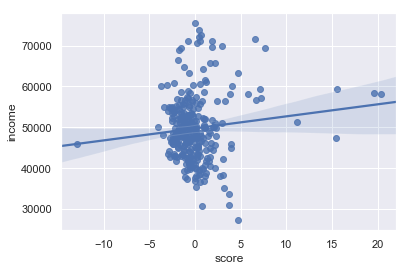

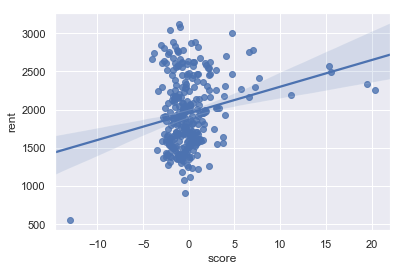

In [159]:
# from correlation.py

result = pgquery(conn, "SELECT * FROM neighbourhoods JOIN censusstats USING (area_id) ORDER BY area_id;", None)
z_score = []
income = []
rent = []
for row in result:
    if row[-1] is not None and row[-2] is not None:
        z_score.append(row[-8])
        income.append(row[-2])
        rent.append(row[-1])

score_income = pd.DataFrame({"score": z_score, "income": income})
score_rent = pd.DataFrame({"score": z_score, "rent": rent})

income_corrcoef = numpy.corrcoef(rent, z_score)[0, 1]
rent_corrcoef = numpy.corrcoef(income, z_score)[0, 1]

plt.figure()
plot1 = sb.regplot(x = "score", y= "income", data = score_income, fit_reg = True)
fig1 = plot1.get_figure()
fig1.savefig("score_income")

plt.figure()
plot2 = sb.regplot(x = "score", y = "rent", data = score_rent, fit_reg = True)
fig2 = plot2.get_figure()
fig2.savefig("score_rent")

print(income_corrcoef)
print(rent_corrcoef)

# Map Overlay

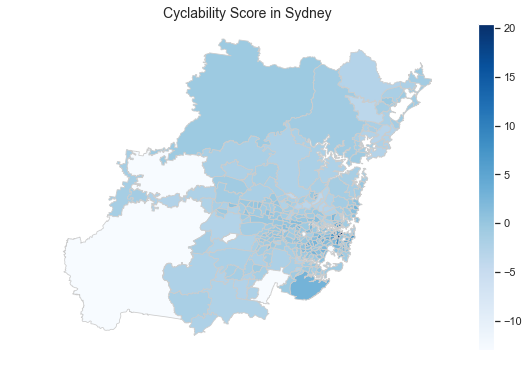

<Figure size 432x288 with 0 Axes>

In [160]:
query = "SELECT geom, cyclability_score FROM neighbourhoods;"
gpd_df = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geom')

query = "SELECT MAX(cyclability_score), MIN(cyclability_score) FROM neighbourhoods;"
result = pgquery(conn, query, None)
v_max = result[0][0]
v_min = result[0][1]
fig1, ax = plt.subplots(1, figsize=(10, 6))

plt.figure()
plot1 = gpd_df.plot(column = "cyclability_score", cmap = "Blues", linewidth = 0.8, ax = ax, edgecolor = '0.8')
plot1.axis("off")
plot1.set_title("Cyclability Score in Sydney", fontdict={"fontsize": "14", "fontweight" : "2"})

fig1 = plot1.get_figure()
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=v_min, vmax=v_max))
sm._A = []
fig1.colorbar(sm)
fig1.savefig("map_overlay")

conn.close()